# Set-Up

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets seqeval

In [ ]:
!pip install accelerate -U

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sho77oe8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sho77oe8
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done


In [ ]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
import pathlib
import numpy as np
import torch
from PIL import Image, ImageDraw
import os
from pdf2image import convert_from_path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Prep

In [ ]:
from datasets import load_dataset

dataset = load_dataset("darentang/sroie")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None)}

(1000, 1000, 3)


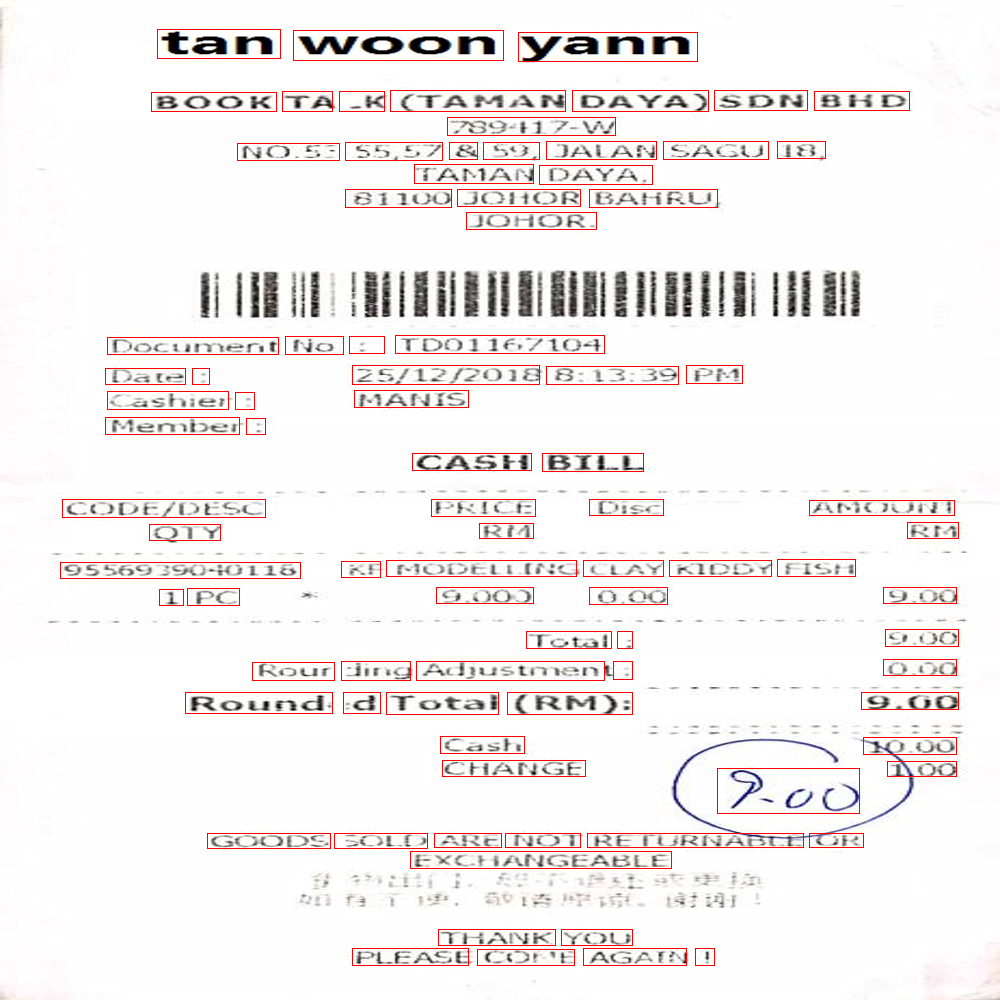

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

example = dataset["train"][0]
image = Image.open(example["image_path"]).resize((1000, 1000))

image_np = np.asarray(image)
print(image_np.shape)

image_draw = ImageDraw.Draw(image)
for box in example['bboxes']:
  image_draw.rectangle([box[0], box[1], box[2], box[3]], outline='red')

image

In [ ]:
words, boxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['tan', 'woon', 'yann', 'BOOK', 'TA', '_K', '(TAMAN', 'DAYA)', 'SDN', 'BHD', '789417-W', 'NO.5:', '55,57', '&', '59,', 'JALAN', 'SAGU', '18,', 'TAMAN', 'DAYA,', '81100', 'JOHOR', 'BAHRU', 'JOHOR.', 'Document', 'No', ':', 'TD01167104', 'Date', ':', '25/12/2018', '8:13:39', 'PM', 'Cashier', ':', 'MANIS', 'Member', ':', 'CASH', 'BILL', 'CODE/DESC', 'PRICE', 'Disc', 'AMOUNT', 'QTY', 'RM', 'RM', '9556939040118', 'KF', 'MODELLING', 'CLAY', 'KIDDY', 'FISH', '1', 'PC', '9.000', '0,00', '9,00', 'Total', ':', '9.00', 'Rour', 'ding', 'Adjustment', ':', '0,00', 'Round', 'd', 'Total', '(RM):', '9.00', 'Cash', '10.00', 'CHANGE', '1.00', '9:00', 'GOODS', 'SOLD', 'ARE', 'NOT', 'RETURNABLE', 'OR', 'EXCHANGEABLE', 'THANK', 'YOU', 'PLEASE', 'COME', 'AGAIN', '!']
[[157, 29, 280, 58], [293, 30, 503, 60], [518, 32, 697, 61], [151, 92, 276, 111], [282, 91, 332, 111], [339, 91, 384, 111], [390, 90, 565, 111], [572, 90, 708, 111], [714, 90, 807, 110], [814, 91, 909, 110], [447, 117, 615, 135], [237, 143, 339, 

In [ ]:
from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=False)

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']


In [ ]:
print(id2label)

{0: 'O', 1: 'B-COMPANY', 2: 'I-COMPANY', 3: 'B-DATE', 4: 'I-DATE', 5: 'B-ADDRESS', 6: 'I-ADDRESS', 7: 'B-TOTAL', 8: 'I-TOTAL'}


In [ ]:
import numpy as np

def convert_paths_to_numpy(image_paths):
  np_images_list = []
  for path in image_paths:
      image_array = np.asarray(Image.open(path))

      # adding third dimenstion for grayscale images
      if len(image_array.shape) != 3:
        image_array = np.dstack((image_array, image_array, image_array))

      np_images_list.append(image_array)

  return np_images_list

def prepare_examples(examples):
  images = convert_paths_to_numpy(examples[image_column_name])
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       padding='max_length', truncation=True, max_length=512)

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'image': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [ ]:
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 626
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> tan woon yann BOOK TA _K (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU JOHOR. Document No : TD01167104 Date : 25/12/2018 8:13:39 PM Cashier : MANIS Member : CASH BILL CODE/DESC PRICE Disc AMOUNT QTY RM RM 9556939040118 KF MODELLING CLAY KIDDY FISH 1 PC 9.000 0,00 9,00 Total : 9.00 Rour ding Adjustment : 0,00 Round d Total (RM): 9.00 Cash 10.00 CHANGE 1.00 9:00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE THANK YOU PLEASE COME AGAIN!</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
train_dataset.set_format("torch")

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

image torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
eval_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 347
})

In [ ]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> tan chay yee *** COPY *** OJC MARKETING SDN BHD ROC NO: 538358-H NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 81750 MASAI, JOHOR Tel:07-388 2218 Fax:07-388 8218 Email: ng@ojcgroup.com TAX INVOICE Invoice No : PEGIV-1030765 Date : 15/01/2019 11:05:16 AM Cashier : NG CHUAN MIN Sales Persor : FATIN Bill To : THE PEAK QUARRY WORKS Address Description Qty Price Amount 000000111 1 193.00 193.00 SR KINGS SAFETY SHOES KWD 805 Qty: 1 Total Exclude GST: 193.00 Total GST @6%: 0.00 Total Inclusive GST: 193.00 Round Amt: 0.00 TOTAL: 193.00 VISA CARD 193,00 xxxxxxxxxxxxxxxx4318 Approval Code:000 93.00 Goods Sold Are Not Returnable & Refundable **** Thank You. Please Come Again.****</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
tan 0
woon 0
yan 0
n -100
 1
BOOK 1
TA 2
_ 2
K -100
( 2
TA -100
MAN -100
D 2
AYA -100
) -100
S 2
DN -100
B 2
HD -100
78 5
94 -100
17 -100
- -100
W -100
NO 6
. -100
5 -100
: -100
55 6
, -100
57 -100
& 6
59 6
, -100
J 6
ALAN -100
S 6
AGU -100
18 6
, -100
TA 6
MAN -100
D 6
AYA -100
, -100
81 6
100 -100
JO 6
HOR -100
 6
BAH 6
RU -100
JO 6
HOR -100
. -100
Document 0
No 0
: 0
TD 0
01 -100
167 -100
104 -100
Date 0
: 0
25 3
/12/2018 -100
8 0
:13 -100
:39 -100
PM 0
Cash 0
ier -100
: 0
MAN 0
IS -100
Member 0
: 0
CAS 0
H -100
B 0
ILL -100
CO 0
DE -100
/ -100
DES -100
C -100
PRI 0
CE -100
Disc 0
 0
AMO 0
UNT -100
Q 0
TY -100
RM 0
RM 0
95 0
569 -100
390 -100
40 -100
118 -100
 0
KF 0
MODEL 0
LING -100
C 0
LAY -100
K 0
ID -100
DY -100
F 0
ISH -100
1 0
PC 0
 7
9.000 7
 0
0,00 0
 0
9,00 0
Total 0
: 0
9.00 0
Ro 0
ur -100
ding 0
Ad 0
just -100
ment -100
: 0
 0
0,00 0
Round 0
d 0
Total 0
( 0
RM -100
): -100
9.00 0
Cash 0
10.00 0
C 0
HAN -100
GE -100
 0
1.00 0
9:00 0
G 0
OOD -100
S -100
SOL 0
D -1

# Define Metrics


In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-27-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

# Define Model

In [ ]:
from transformers import LayoutLMv2ForTokenClassification

model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutxlm-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv2ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutxlm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1250,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

# Train and Save Model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.075601,0.797181,0.685984,0.737414,0.981461
200,No log,0.048262,0.804678,0.857817,0.830398,0.987151
300,No log,0.047482,0.796383,0.919811,0.853659,0.987664
400,No log,0.043864,0.777219,0.938005,0.850076,0.987594
500,0.104600,0.038822,0.837237,0.939353,0.885360,0.990556
600,0.104600,0.034052,0.843693,0.942049,0.890162,0.991745
700,0.104600,0.031793,0.889673,0.934636,0.911600,0.992864
800,0.104600,0.031301,0.880606,0.939353,0.909032,0.992771
900,0.104600,0.028610,0.886924,0.946092,0.915553,0.993377
1000,0.028200,0.028343,0.900901,0.943396,0.921659,0.993984


TrainOutput(global_step=1250, training_loss=0.056956123733520506, metrics={'train_runtime': 1023.4387, 'train_samples_per_second': 2.443, 'train_steps_per_second': 1.221, 'total_flos': 1349660413440000.0, 'train_loss': 0.056956123733520506, 'epoch': 3.99})

In [ ]:
trainer.save_model('/content/drive/MyDrive/layoutmv3_checkpoint')

In [ ]:
trainer.evaluate()

{'eval_loss': 0.02834322489798069,
 'eval_precision': 0.9009009009009009,
 'eval_recall': 0.9433962264150944,
 'eval_f1': 0.9216589861751152,
 'eval_accuracy': 0.9939836298766411,
 'eval_runtime': 35.4185,
 'eval_samples_per_second': 9.797,
 'eval_steps_per_second': 4.913,
 'epoch': 3.99}

# True Inference (SROIE + rus. ex.)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# load model and processor
from transformers import LayoutLMv2ForTokenClassification

model_ = LayoutLMv2ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutXLM_checkpoint")

from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", apply_ocr=True)

model_.to(device);

In [ ]:
from datasets import load_dataset

dataset = load_dataset("darentang/sroie")
test_example = dataset['test'][0]
test_im = np.asarray(Image.open(test_example['image_path']))

In [ ]:
encoding = processor(test_im, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'image'])


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
# forward pass
outputs = model_(**encoding)
print(outputs.logits.shape)

torch.Size([1, 203, 9])


In [ ]:
def unnormalize_1000_box(bbox, width, height):
     return [
         int(width * (bbox[0] / 1000)),
         int(height * (bbox[1] / 1000)),
         int(width * (bbox[2] / 1000)),
         int(height * (bbox[3] / 1000)),
     ]

In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = Image.open(test_example['image_path']).size

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

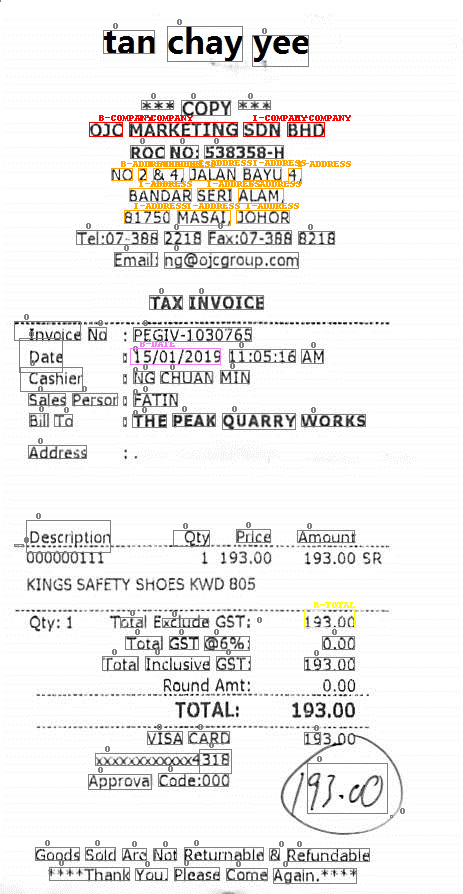

In [ ]:
test_im_pil = Image.open(test_example['image_path'])
draw = ImageDraw.Draw(test_im_pil)

def iob_to_label(label):
    if not label:
      return 'O'
    return label

label2color = {'O':'gray', 'B-COMPANY':'red', 'I-COMPANY':'red', 'B-ADDRESS': 'orange',
               'I-ADDRESS': 'orange', 'B-DATE':'violet', 'I-DATE':'violet', 'B-TOTAL':'yellow', 'I-TOTAL':'yellow'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

test_im_pil

In [ ]:
# rus. pdf receipt

test_im = convert_from_path(pathlib.Path('/content/drive/MyDrive/receipt_dataset/cool_example.pdf'))[0]

encoding = processor(test_im, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'image'])


In [ ]:
for k,v in encoding.items():
  encoding[k] = v.to(device)

In [ ]:
# forward pass
outputs = model_(**encoding)
print(outputs.logits.shape)

torch.Size([1, 361, 9])


In [ ]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = test_im.size

In [ ]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

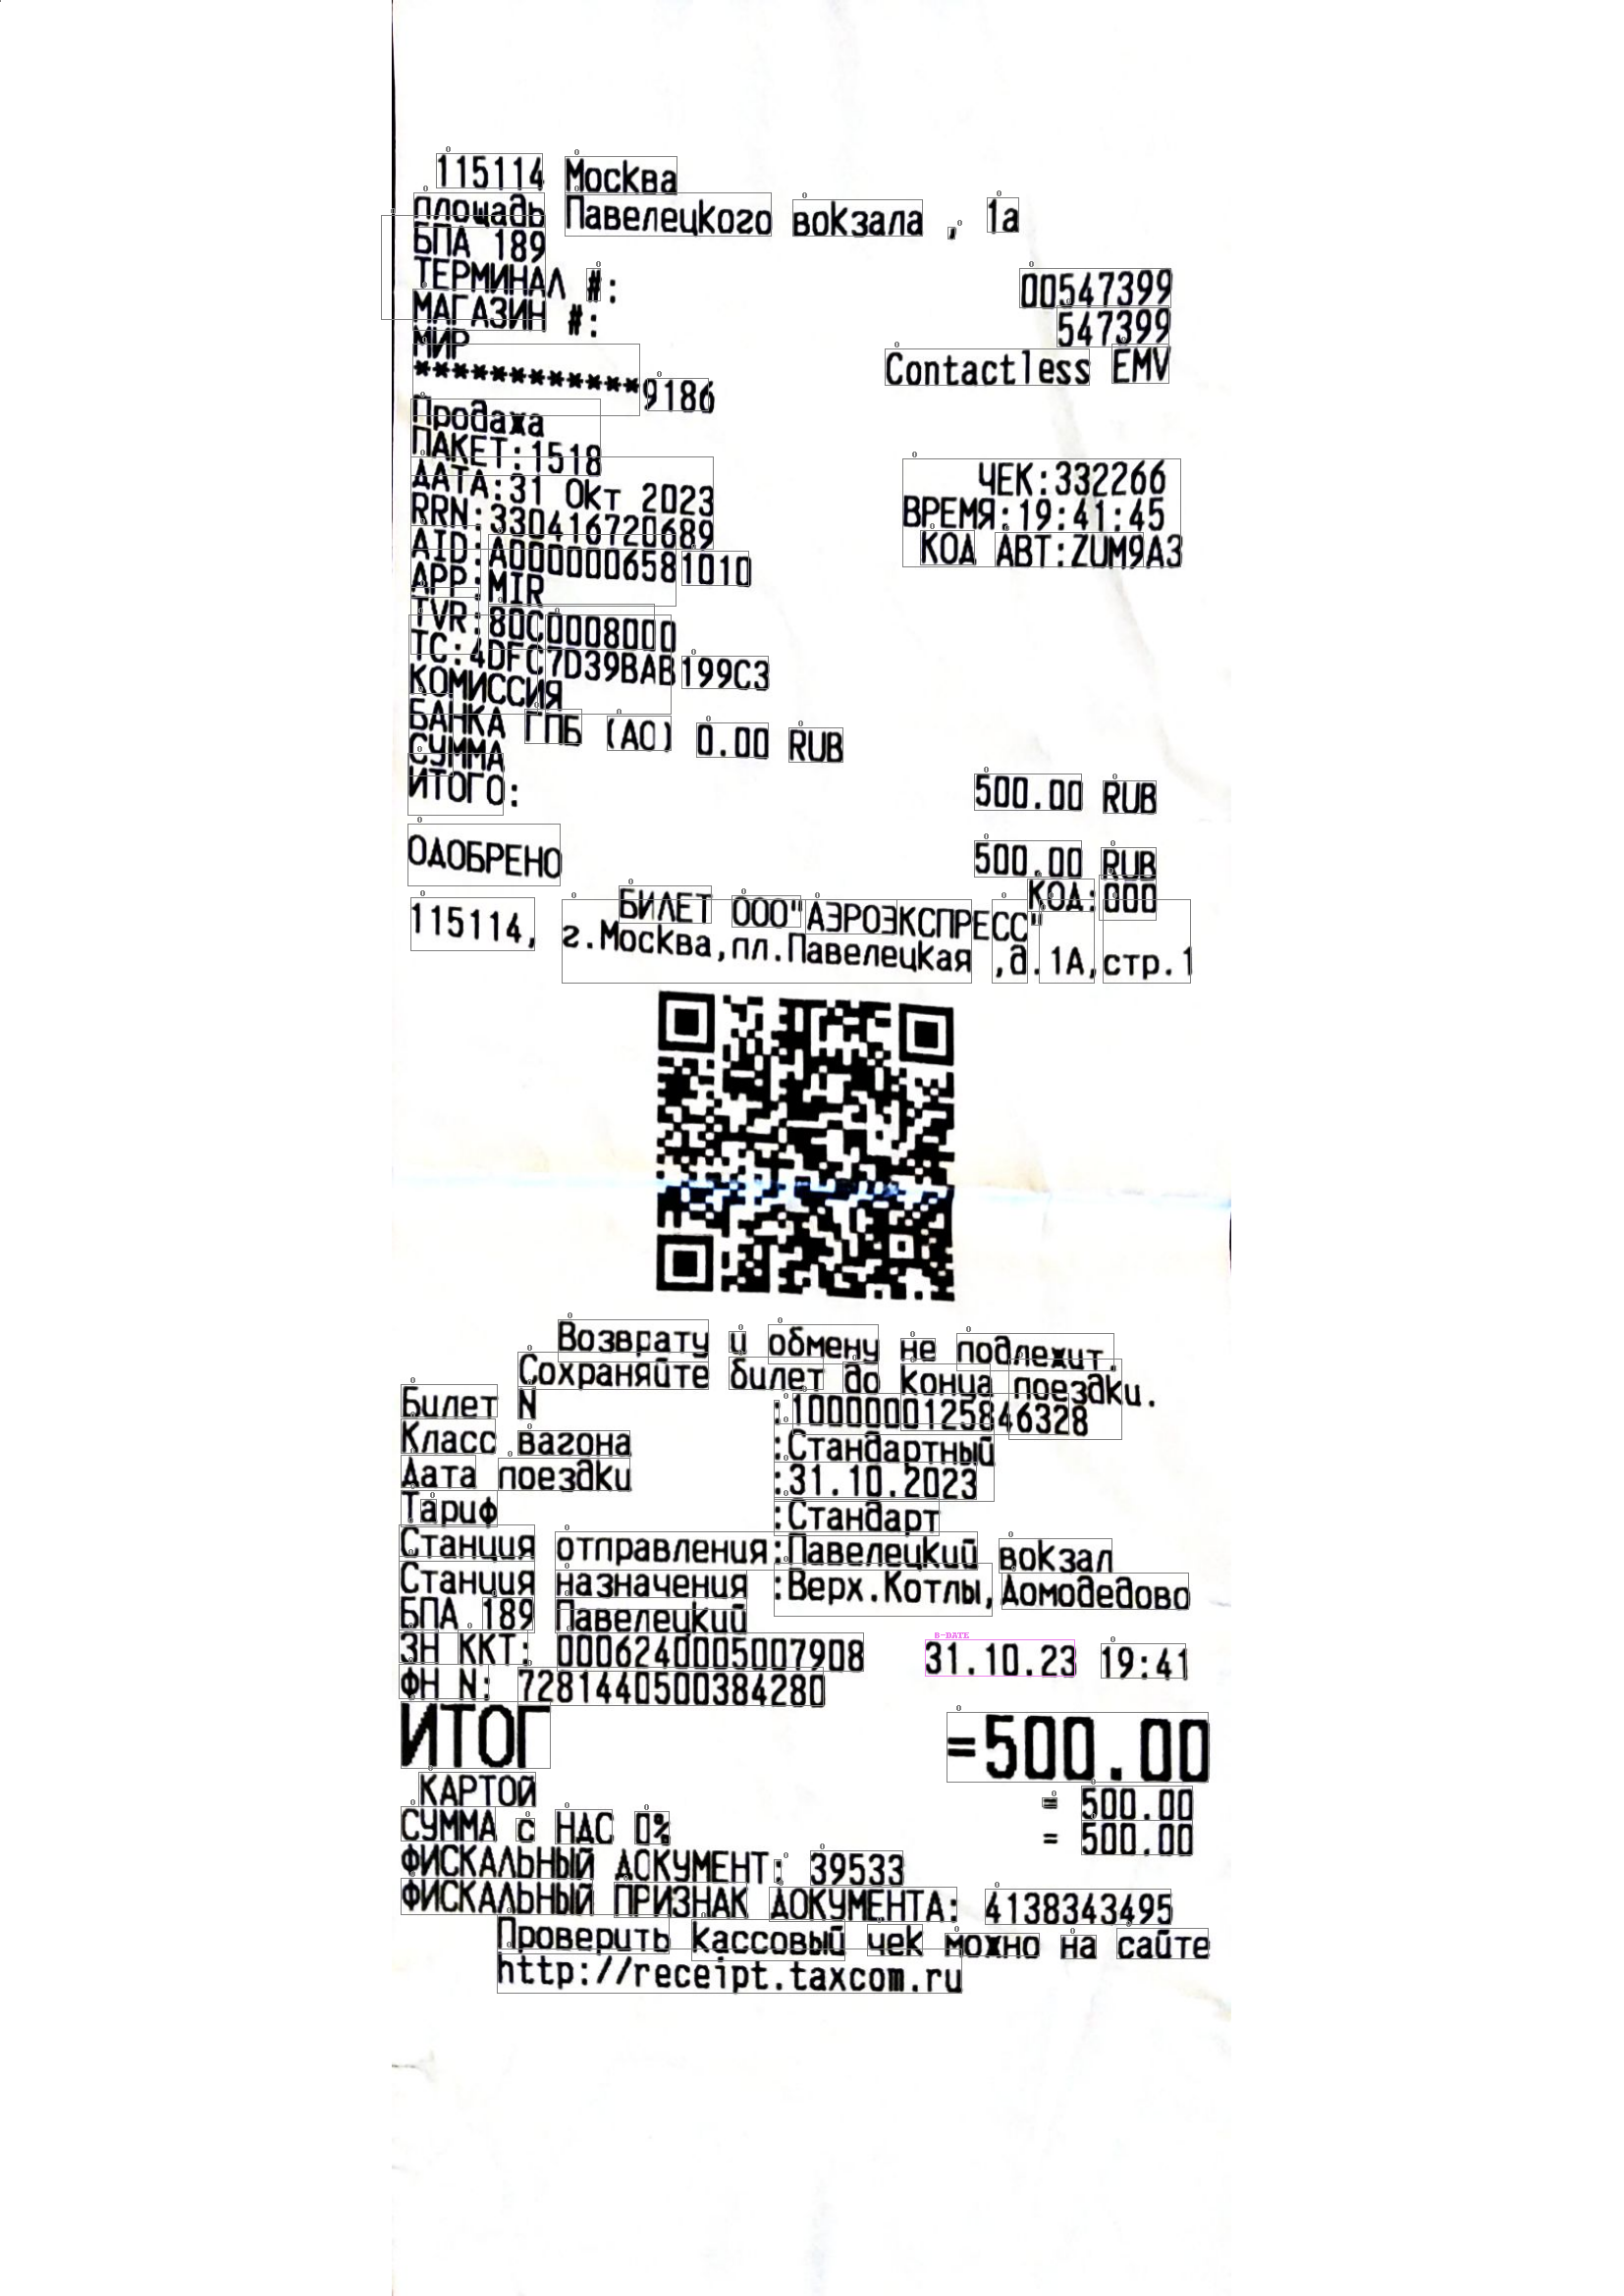

In [ ]:
draw = ImageDraw.Draw(test_im)

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label])

test_im